In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
from scipy import stats
import urllib.request, json
from pandas.io.json import json_normalize
from requests.exceptions import ConnectionError


In [34]:
#from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics

# ---- Create datafranes # -------
def createDF():
    
    # LSTM Series , prediction for temp, pressure & windspeed  
    url = 'http://api.openweathermap.org/data/2.5/forecast?q=Singapore,sg&appid=0a3e9078edb04a4b68edf24cef43e65e&units=metric'
    res = requests.get(url)
    data = res.json()
    
    df_normalize_data = json_normalize(data['list']) #getting the whole list
    df_normalize = json_normalize(data['list'], 'weather') #getting only weather list
    df_data = df_normalize_data.drop(['weather','dt','sys.pod'], axis=1).join(df_normalize)
    df_rename = df_data.rename(columns={"dt_txt":'DateTime'})
    return df_rename


# ----  Set column as index ----
def setIndex(dataset,columnName):
    date_index = pd.Series(dataset[columnName])
    target_date = dataset.set_index(pd.Index(date_index,'Date')).drop(columnName,axis=1)
    return target_date


In [39]:
df_rename = setIndex(createDF(),'DateTime')
df = df_rename.drop(['icon','main','description'], axis=1)
# df.values.shape
df_ren.head(1)

,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.sea_level,main.grnd_level,main.humidity,main.temp_kf,clouds.all,wind.speed,wind.deg,rain.3h,id
DateTime,,,,,,,,,,,,,,
2020-04-12 12:00:00,28.02,32.12,27.72,28.02,1009,1009,1006,82,0.3,97,3.01,53,1.45,500


Text(0.5, 0, ' ')

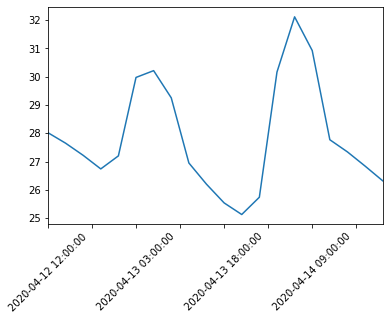

In [40]:
df['main.temp']['2020-04-12':'2020-04-15'].plot()
plt.xticks(rotation=45)
plt.xlabel(' ')

In [7]:
#Adding column of day and hour or better visualisation at a. later stage
# df['Various','Day'] = df.index
# df.head(1)

In [126]:
# --- Target data to predict ----
# 24 - is predicting 24hrs ahead

target_name = ['main.temp','wind.speed','main.pressure']
shift_days = 1
shift_steps = shift_days * 24

# Negetive shiftsteps is predicting into the future 
df_targets = df[target_name].shift(-shift_steps)
# df[target_name].head(shift_steps + 5)

In [127]:
# Using numpy to insert data for neural network 

#input signals 
x_data = df.values[0:-shift_steps]
#output signals 
y_data = df_targets.values[:-shift_steps]

In [143]:
#number of observation
num_data = len(x_data)

#training sets
train_split = 0.7

#observation training set 
num_train = int(train_split * num_data)
print('Observation training set %s ' % num_train)

#Observation test set 
num_test = num_data - num_train
print('Test set is %s'% num_test)

Observation training set 11 
Test set is 5


In [144]:
# input signals or training - and test sets
x_train = x_data[0:num_train]
x_test = x_data[num_train:]


In [145]:
# output signal for training and test -sets
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

16

In [175]:
# number of input signals 
num_x_signals = x_data.shape[1]
num_x_signal

14

In [190]:
# number of output signals
num_y_signals = y_data.shape[1]
num_y_signals
x_train

array([[2.802e+01, 3.212e+01, 2.772e+01, 2.802e+01, 1.009e+03, 1.009e+03,
        1.006e+03, 8.200e+01, 3.000e-01, 9.700e+01, 3.010e+00, 5.300e+01,
        1.450e+00, 5.000e+02],
       [2.765e+01, 3.165e+01, 2.742e+01, 2.765e+01, 1.011e+03, 1.011e+03,
        1.008e+03, 8.500e+01, 2.300e-01, 1.000e+02, 3.370e+00, 4.500e+01,
        3.100e-01, 5.000e+02],
       [2.722e+01, 3.081e+01, 2.707e+01, 2.722e+01, 1.009e+03, 1.009e+03,
        1.007e+03, 8.700e+01, 1.500e-01, 9.700e+01, 3.930e+00, 3.800e+01,
        5.000e-01, 5.000e+02],
       [2.674e+01, 3.017e+01, 2.666e+01, 2.674e+01, 1.008e+03, 1.008e+03,
        1.005e+03, 8.800e+01, 8.000e-02, 6.700e+01, 3.910e+00, 4.100e+01,
        6.700e-01, 5.000e+02],
       [2.720e+01, 3.025e+01, 2.720e+01, 2.720e+01, 1.009e+03, 1.009e+03,
        1.007e+03, 8.500e+01, 0.000e+00, 7.500e+01, 4.340e+00, 3.700e+01,
        1.560e+00, 5.000e+02],
       [2.997e+01, 3.312e+01, 2.997e+01, 2.997e+01, 1.011e+03, 1.011e+03,
        1.009e+03, 7.100e+01, 0

##Scaled data - neural network 

In [189]:
#(require all fiends to be in numerical)
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [149]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(11, 14)
(11, 3)


#Generator

In [166]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)


In [181]:
batch_size = 10

In [232]:
sequence_length = 10
sequence_length

10

In [233]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)


In [234]:
x_batch, y_batch = next(generator)

In [215]:
print(x_batch.shape)
print(y_batch.shape)

(10, 10, 14)
(10, 10, 3)


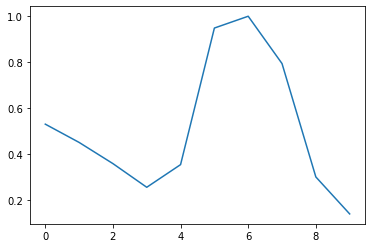

In [235]:
#plot first 10 sets
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

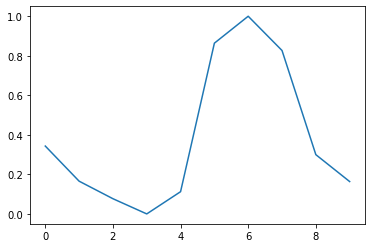

In [236]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

#Validation

In [237]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [239]:
# Create Recurrent Neural Network 

model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [240]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [241]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [ ]:
#MSE Function

In [243]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [246]:
#Compiler model 
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer = optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         811008    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 812,547
Trainable params: 812,547
Non-trainable params: 0
_________________________________________________________________


In [247]:
# Call back function 
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [249]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [248]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [250]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [251]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

Recurrent Neural Network 

In [252]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

  ...
    to  
  ['...']
Train for 100 steps, validate on 1 samples
Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: nan
Epoch 00001: val_loss did not improve from inf

Epoch 00001: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 10s 98ms/step - loss: nan - val_loss: nan
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: nan
Epoch 00002: val_loss did not improve from inf

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 7s 75ms/step - loss: nan - val_loss: nan
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: nan
Epoch 00003: val_loss did not improve from inf
100/100 [==============================] - 7s 73ms/step - loss: nan - val_loss: nan
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: nan
Epoch 00004: val_loss did not improve from inf
100/100 [==============================] - 7s 7

In [254]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = '23_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [255]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 5ms/sample - loss: nan


In [268]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_name)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_name[signal])
        plt.legend()
        plt.show()

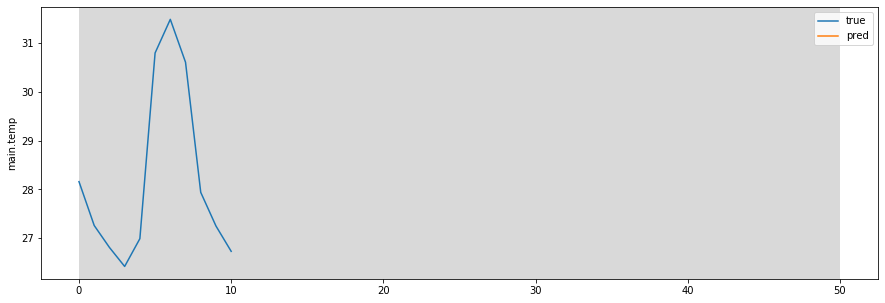

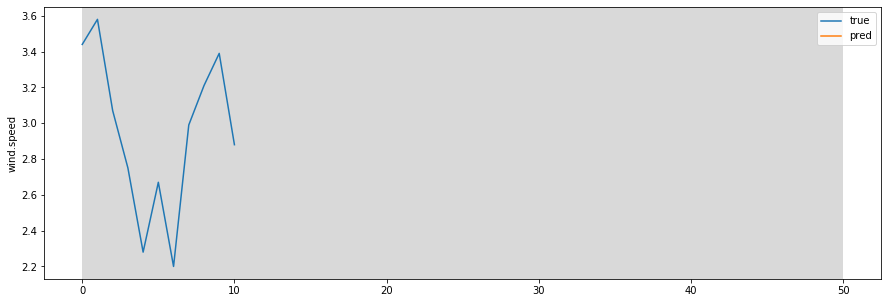

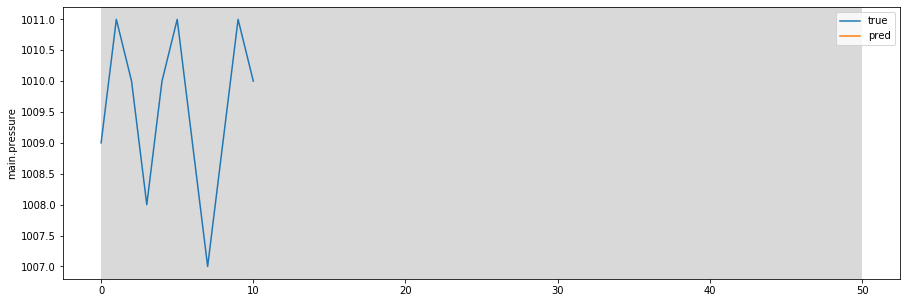

In [270]:
plot_comparison(start_idx=0, length=30, train=True)